## Step by Step plots of what LOESS (LOcally Estimated Scatterplot Smoothing)

Using notation from Cleveland (1979), the goal is to determine $\{\hat{y}_i\}$, estimates of $\{y_i\}$ from points $(x, y) \in \{(x_i, y_i)\}$

Comparing to software package from Cappellari et al. (2013) => same example as found in loess_1d

NOTES:
1. After this works, determine if we can save time by caching grid / stencil for regression
1. Expand to 2D and then data on globe (=> maybe convert $(\lambda, \theta)$ on unit circle to $(x, y, z=\sqrt{1-x^2-y^2})$

In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from loess.loess_1d import loess_1d

In [2]:
# Place figures within document
# This is in its own cell otherwise rcParams set is ignored
# (Possibly related to https://github.com/jupyter/notebook/issues/3385)
%matplotlib inline
matplotlib.rcParams['figure.figsize'] = (12.0, 8.0) # Large figures

In [3]:
# use same x values as in Loess example, because why not
tot_points = 200
np.random.seed(123)
x = np.random.uniform(-1, 1, tot_points)
x.sort()

y_true = np.sin(3*x)
sigy = 0.4
y_eval = np.random.normal(y_true, sigy)

nbad = int(tot_points*0.1) # 10% outliers
w = np.random.randint(0, tot_points, nbad)  # random indices from 0-n
y_eval[w] += np.random.normal(0, 5*sigy, nbad)

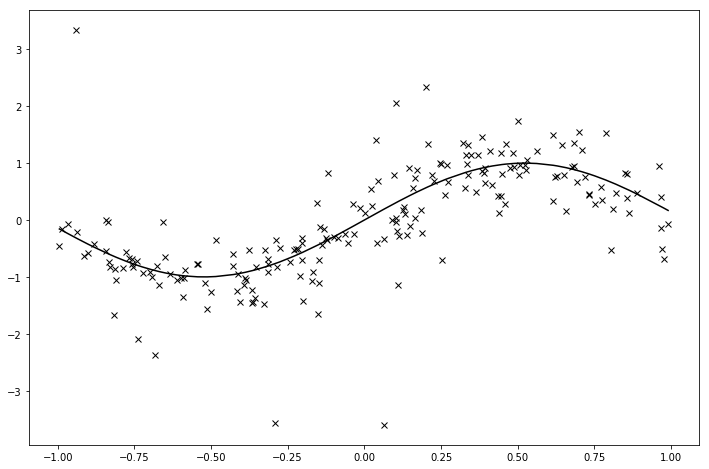

In [4]:
plt.plot(x, y_true, 'k')
plt.plot(x, y_eval, 'kx')

#### 1. Polynomial fit

For this step, we fit a polynomial of degree $d$ to the $n$ points $(x_j, y_j)$ where $x_j$ represents the $n$ closest points to $x_i$.
Use weighted regression with weight function W(x) = (1 - (|x_i - x_j|/h_i)^3)^3$, where $h_i = \max(|x_i - x_j|)$ among the $n$ points

In [5]:
def W(x, h):
    """
    Tricube weight function from Cleveland (1979)
    We should only be calling this for points where |x| <= h
    """
    return np.where(np.abs(x) < h, (1 - np.abs(x/h)**3)**3, 0)

def B(x):
    return np.where(np.abs(x)<1, (1 - x**2)**2, 0)

def polyfit_at_point_i(x, y, i, n, d, t=0):
    """ Given a global set of (x,y) and an index i:
        1. Find the n x-coordinates closest to x[i]
        2. Fit a polynomial of degree d to those points
        3. Return polynomial coefficients as well as all (x,y) values used to determine polynomial
        4. Apply robustness t times
    """
    # Find n smallest values (via https://stackoverflow.com/questions/5807047/efficient-way-to-take-the-minimum-maximum-n-values-and-indices-from-a-matrix-usi)
    hi = np.partition(np.abs(x[i] - x), n-1)[:n]
    h = np.max(hi)
    j_ind = np.argpartition(np.abs(x[i] - x), n-1)[:n]
    xj = x[j_ind]
    yj = y_eval[j_ind]

    # Regression: yj ~= sum b_n * (xj**n)
    betas = np.polyfit(xj, yj, d, w=np.sqrt(W(x[i] - xj, h)))[::-1]
    for _ in range(t):
        yhat = np.zeros(n)
        for p, beta in enumerate(betas):
            yhat += beta*(xj**p)
        residuals = np.abs(yhat - yj)
        s = np.median(np.abs(residuals))
        delta = B(residuals/(6*s))
        betas = np.polyfit(xj, yj, d, w=np.sqrt(delta*W(x[i] - xj, h)))[::-1]

    return betas, xj, yj

def RMSE(est_val, true_val):
    """ sqrt(1/n * sum of square differences)
    """
    assert len(est_val) == len(true_val), "Arrays must be same size"
    N = len(est_val)
    print("RMSE: {:.4f}".format(np.sqrt(np.sum((est_val - true_val)**2)/N)))

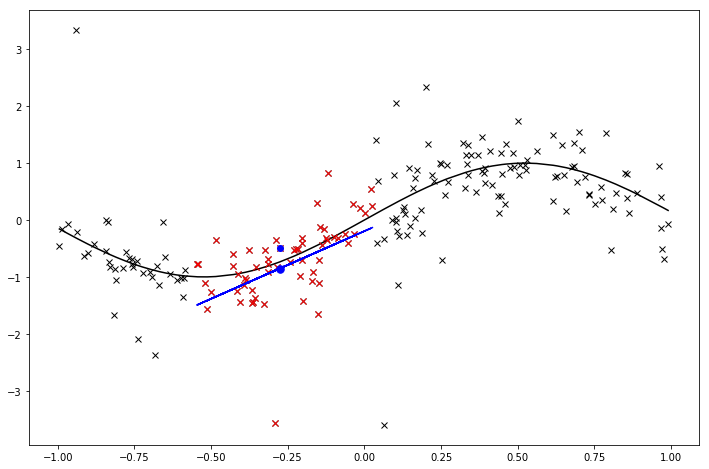

In [6]:
# Choose n and d
n = 60 # 30% of tot_points
d = 1  # We will use linear regression

# Pick a point ~1/3 of the way into the domain
i = tot_points//3

betas, xj, yj = polyfit_at_point_i(x, y_eval, i, n, d)

yhati = 0
yhat = np.zeros(xj.shape)
for p, beta in enumerate(betas):
    yhati += beta * (x[i]**p)
    yhat  += beta * (xj**p)

# True distribution is solid black
plt.plot(x, y_true, 'k')
# Sampled data in black x
plt.plot(x, y_eval, 'kx')
# Sampled data used for local regression in red x
plt.plot(xj, yj, 'rx')
# Node i in red dot
plt.plot(x[i], y_eval[i], 'bo')
# Local polynomial fit in solid blue
plt.plot(xj, yhat, 'b')
# Estimated value at x[i] is big blue *
plt.plot(x[i], yhati, 'bo', markersize=7.5)

#### 2. Repeat this process for all nodes

In [7]:
%%time

# Choose n and d
n = 60 # 30% of tot_points
d = 1  # We will use linear regression

yhat = np.zeros(tot_points)
for i in range(0, tot_points):
    betas, _, _ = polyfit_at_point_i(x, y_eval, i, n ,d)
    for p, beta in enumerate(betas):
        yhat[i] += beta * (x[i]**p)

RMSE(yhat, y_true)

RMSE: 0.0947
CPU times: user 81.1 ms, sys: 18.5 ms, total: 99.6 ms
Wall time: 44.5 ms


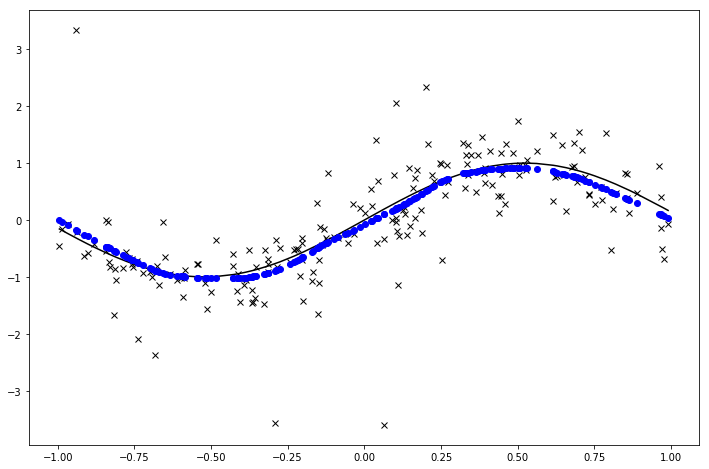

In [8]:
# True distribution is solid black
plt.plot(x, y_true, 'k')
# Sampled data in black x
plt.plot(x, y_eval, 'kx')
# Estimated value at each x[i] is blue dot
plt.plot(x, yhat, 'bo')

#### 3. Apply Robustness Weights

In [9]:
%%time

yhat2 = np.zeros(tot_points)
for i in range(0, tot_points):
    betas, _, _ = polyfit_at_point_i(x, y_eval, i, n ,d, t=2)
    for p, beta in enumerate(betas):
        yhat2[i] += beta * (x[i]**p)

RMSE(yhat2, y_true)

RMSE: 0.0768
CPU times: user 180 ms, sys: 17.5 ms, total: 198 ms
Wall time: 134 ms


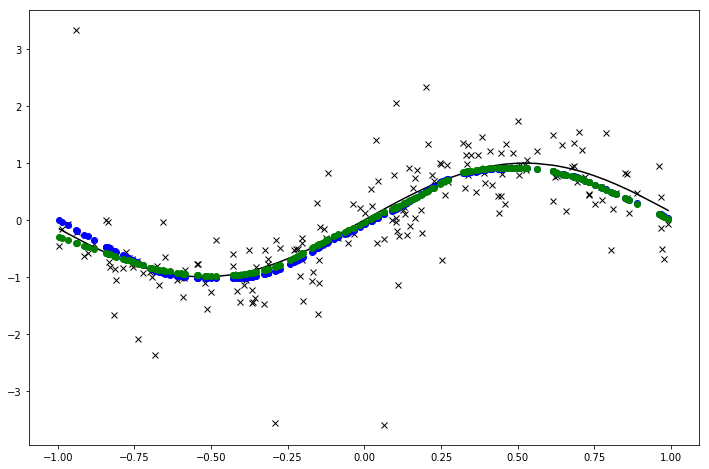

In [10]:
# True distribution is solid black
plt.plot(x, y_true, 'k')
# Sampled data in black x
plt.plot(x, y_eval, 'kx')
# Original estimated value at each x[i] is blue dot
plt.plot(x, yhat, 'bo')
# Robust estimated values at each x[i] is green dot
plt.plot(x, yhat2, 'go')

#### Compare to loess_1d package

CPU times: user 131 ms, sys: 12.9 ms, total: 144 ms
Wall time: 97.6 ms
RMSE: 0.0765
Largest difference between loess package and code above: 0.0086156502500922


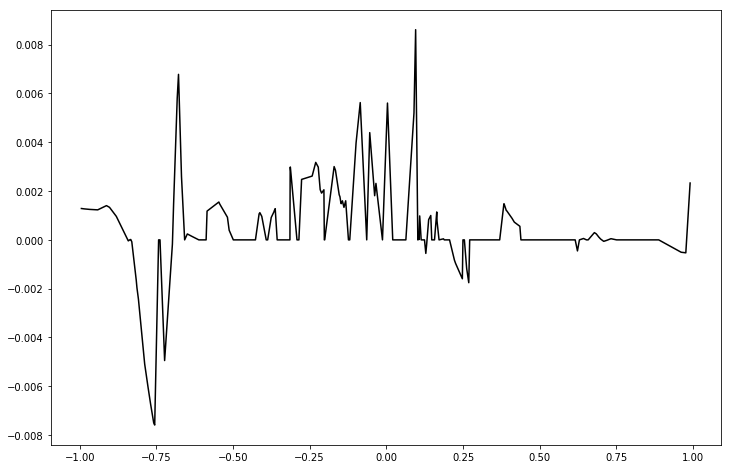

In [11]:
%time xout, yout, weigts = loess_1d(x, y_eval, frac=0.3)
RMSE(yout, y_true)

diff = yout - yhat2
plt.plot(x, diff, 'k')
print("Largest difference between loess package and code above: {}".format(np.max(np.abs(diff))))

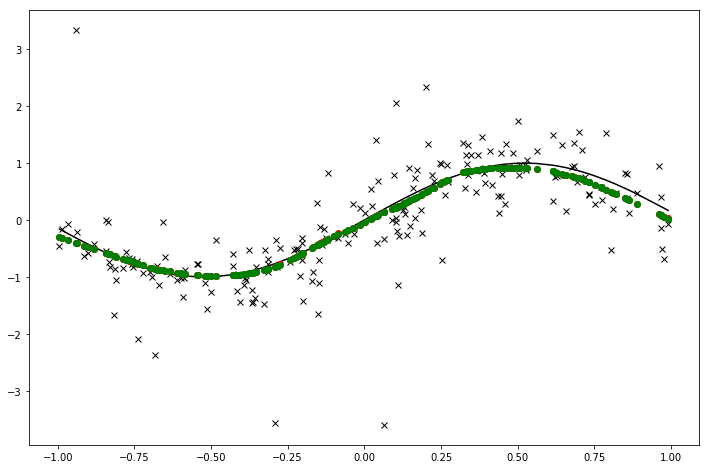

In [12]:
# True distribution is solid black
plt.plot(x, y_true, 'k')
# Sampled data in black x
plt.plot(x, y_eval, 'kx')
# loess package estimated value at each x[i] is red dot
plt.plot(x, yout, 'ro')
# My estimated value at each x[i] is green dot
plt.plot(x, yhat2, 'go')